In [30]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import sys
import torch
from   torch.utils import data

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from data.data_utils import Dataset

## Compare Sin results

### load data

In [31]:
data_path_test = '../data/sin/sin-te-data.pkl'
data_path_train = '../data/sin/sin-tr-data.pkl'
device = 'cpu'
dtype = torch.float64
batch_size = 10
shuffle = False
num_workers = 0

In [32]:
X_te = torch.load(data_path_test)
X_te = X_te.to(device).to(dtype)
X_tr = torch.load(data_path_train)
X_tr = X_tr.to(device).to(dtype)


In [33]:
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers, 'drop_last': True}
trainset = Dataset(X_tr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(X_te)
testset  = data.DataLoader(testset, **params)

### load models

In [34]:
from model.core.invodevae import INVODEVAE
from model.core.flow import Flow
from model.core.vae import VAE
from model.core.mlp import MLP
from model.core.inv_enc import INV_ENC

# Solver

##### Node + inv + contrastive

In [42]:
T_in = 3
T_inv = 10
ode_latent_dim = 4
inv_latent_dim = 4 
order = 1 
D_in  = ode_latent_dim + inv_latent_dim
D_out = int(ode_latent_dim / order)
frames = 5
dt = 0.1
aug = True
Nobj = 1
task ='sin'
n_filt = 16
num_layers = 2 
num_hidden = 200
rnn_hidden = 10
decoder_H = 100
dec_act = 'relu'
cnn_arch = 'dcgan'
last_layer_gp  = None

In [43]:


sinode_euler = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver='euler', use_adjoint='no_adjoint'),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)


sinode_rk = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver='rk4', use_adjoint='no_adjoint'),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

sinode_dopri = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver='dopri5', use_adjoint='no_adjoint'),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [44]:
sinode_euler.to(device)
fname = '../results/sin/22_03_2023-14:45/invodevae_200_.pth'
sinode_euler.load_state_dict(torch.load(fname,map_location=torch.device(device)))
sinode_euler.eval()


sinode_rk.to(device)
fname = '../results/sin/22_03_2023-11:19/invodevae_1800_.pth'
sinode_rk.load_state_dict(torch.load(fname,map_location=torch.device(device)))
sinode_rk.eval()


sinode_dopri.to(device)
fname = '../results/sin/15_03_2023-23:26/invodevae.pth'
sinode_dopri.load_state_dict(torch.load(fname,map_location=torch.device(device)))
sinode_dopri.eval()



INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=4, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=8, bias=True)
        )
        (gru): GRU(1, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=100, bias=True)
        

##### Node + inv 

In [45]:

inode_euler = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver='euler', use_adjoint='no_adjoint'),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)



inode_rk = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver='rk4', use_adjoint='no_adjoint'),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

inode_dopri = INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver='dopri5', use_adjoint='no_adjoint'),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = INV_ENC(task=task, last_layer_gp=last_layer_gp, inv_latent_dim=inv_latent_dim,
                                            n_filt=n_filt, rnn_hidden=10, T_inv=T_inv, device=device).to(dtype),
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [46]:
inode_euler.to(device)
fname = '../results/sin/22_03_2023-14:46/invodevae_200_.pth'
inode_euler.load_state_dict(torch.load(fname,map_location=torch.device(device)))
inode_euler.eval()


inode_rk.to(device)
fname = '../results/sin/22_03_2023-11:20/invodevae_1800_.pth'
inode_rk.load_state_dict(torch.load(fname,map_location=torch.device(device)))
inode_rk.eval()


inode_dopri.to(device)
fname ='../results/sin/15_03_2023-23:27/invodevae.pth'
inode_dopri.load_state_dict(torch.load(fname,map_location=torch.device(device)))
inode_dopri.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=8, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=4, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=8, bias=True)
        )
        (gru): GRU(1, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=100, bias=True)
        

##### Node 

In [47]:
T_in = 10
inv_latent_dim=0
D_in = ode_latent_dim
D_out = int(D_in/order)
aug=False
node_euler= INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver='euler', use_adjoint='no_adjoint'),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = None,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)


node_rk= INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver='rk4', use_adjoint='no_adjoint'),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = None,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

node_dopri= INVODEVAE(flow = Flow(diffeq= MLP(D_in, D_out, L=num_layers, H=num_hidden, act='softplus').to(dtype), order=order, solver='dopri5', use_adjoint='no_adjoint'),
                        vae = VAE(task=task, v_frames=frames, n_filt=n_filt, ode_latent_dim=ode_latent_dim, 
                                    dec_act=dec_act, rnn_hidden=rnn_hidden, H=decoder_H, 
                                    inv_latent_dim=inv_latent_dim, T_in=T_in, order=order, cnn_arch=cnn_arch, device=device).to(dtype),
                        inv_enc = None,
                        order = order,
                        steps = frames,
                        dt  = dt,
                        aug = aug,
                        nobj=Nobj)

In [48]:
node_euler.to(device)
fname = '../results/sin/22_03_2023-14:47/invodevae_200_.pth'
node_euler.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_euler.eval()


node_rk.to(device)
fname = '../results/sin/22_03_2023-11:21/invodevae_1800_.pth'
node_rk.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_rk.eval()


node_dopri.to(device)
fname = '../results/sin/15_03_2023-23:40/invodevae.pth'
node_dopri.load_state_dict(torch.load(fname,map_location=torch.device(device)))
node_dopri.eval()

INVODEVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=200, bias=True)
          (1): Linear(in_features=200, out_features=200, bias=True)
          (2): Linear(in_features=200, out_features=4, bias=True)
        )
        (acts): ModuleList(
          (0): Softplus(beta=1, threshold=20)
          (1): Softplus(beta=1, threshold=20)
          (2): Identity()
        )
      )
    )
  )
  (vae): VAE(
    (encoder): EncoderRNN(
      (sp): Softplus(beta=1, threshold=20)
      (gru): GRUEncoder(
        (rnn_hidden_to_latent): Sequential(
          (0): Linear(in_features=10, out_features=50, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=50, out_features=8, bias=True)
        )
        (gru): GRU(1, 10)
      )
    )
    (decoder): Decoder(
      (net): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=4, out_features=100, bias=True)
        

## Compute MSE

In [148]:
def compute_mse(model, dataset, T_inv=10, T=50, T_forecast=150, L=20, Eps=10): 
    T_set = [T_inv, T, T_forecast]
    dict_mse = {str(T):(None,None) for T in T_set}
    for T in T_set:
        mses=[]
        #for ep in range(Eps): #check one more time
        for data_batch in dataset:
            data_batch = data_batch.to(model.device)
            [N_,T_,d] = data_batch.shape
            if T_ != T:
                t0s = torch.randint(0,T_-T,[N_])
                in_data= torch.stack([data_batch[n,t0:t0+T] for n,t0 in enumerate(t0s)])
            else:
                in_data = data_batch
            Xrec, ztL, (s0_mu, s0_logv), (v0_mu, v0_logv), C = model(in_data, L, T_custom=T)
            mse   = torch.mean((Xrec-in_data)**2)
            mses.append(mse.item())
        
        dict_mse[str(T)] = (np.mean(np.array(mses)), np.std(np.array(mses)))
    return dict_mse

def plot_mse(model_inv_contr, model_inv, model_base, title):
    fig = plt.figure(figsize=(5,5))
    x = [1,2,3]

    plt.errorbar(x, [item[0] for key, item in model_base.items()], yerr=[item[1] for key, item in model_base.items()], ls='-.', marker="s", color="royalblue", label='NODE', capsize=5)
    plt.errorbar(x, [item[0] for key, item in model_inv.items()], yerr=[item[1] for key, item in model_inv.items()], ls=':', marker="v", color="darkviolet", label='INODE', capsize=5)
    plt.errorbar(x, [item[0] for key, item in model_inv_contr.items()], yerr=[item[1] for key, item in model_inv_contr.items()], ls='--', marker="o", color="seagreen", label='SINODE', capsize=5)

    plt.xticks(x, [key for key, item in model_inv_contr.items()], rotation='horizontal')
    plt.legend(loc='upper left')
    plt.ylabel('Test MSE', fontdict={"size":16})
    plt.xlabel('Prediction Horizon', fontdict={"size":16})
    plt.title(title)
    plt.grid()
    plt.show()

def plot_mse_custom():
    fig = plt.figure(figsize=(5,5))
    x = [1,2,3]
    sinode = {'10':(0.042,0.006), '50':(0.059,0.011), '150':(0.453,0.077)}
    inode = {'10':(0.041,0.010), '50':(0.083,0.026), '150':(0.398,0.179)}
    node = {'10':(0.201,0.015), '50':(0.400,0.066), '150':(2.640,0.872)}
    latentode = {'10':(0.290,0.022), '50':(2.921,0.238), '150':(3.016,0.121)}

    plt.errorbar(x, [item[0] for key, item in latentode.items()], yerr=[item[1] for key, item in latentode.items()], ls='-', marker="*", color="orange", label='Latent-ODE (Rubanova)', capsize=5)
    plt.errorbar(x, [item[0] for key, item in node.items()], yerr=[item[1] for key, item in node.items()], ls='-.', marker="s", color="royalblue", label='NODE', capsize=5)
    plt.errorbar(x, [item[0] for key, item in inode.items()], yerr=[item[1] for key, item in inode.items()], ls=':', marker="v", color="darkviolet", label='INODE', capsize=5)
    plt.errorbar(x, [item[0] for key, item in sinode.items()], yerr=[item[1] for key, item in sinode.items()], ls='--', marker="o", color="seagreen", label='SINODE', capsize=5)

    plt.xticks(x, [key for key, item in sinode.items()], rotation='horizontal')
    plt.legend(loc='upper left')
    plt.ylabel('Test MSE', fontdict={"size":16})
    plt.xlabel('Prediction Horizon', fontdict={"size":16})
    plt.grid()
    plt.show()

def count_params(name, model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters]) 
    print('{} parameters: {}'.format(name,params))

In [294]:
count_params('SINODE', sinode_euler)
count_params('INODE', inode_euler)
count_params('NODE', node_euler)

SINODE parameters: 55998
INODE parameters: 55998
NODE parameters: 54054


### Euler

### After 200 sec

In [149]:
sinode_euler_mse = compute_mse(sinode_euler, testset)
for key,item in sinode_euler_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.163 (0.024)
Sequence length 50 with mse 0.360 (0.040)
Sequence length 150 with mse 1.252 (0.025)


In [150]:
inode_euler_mse = compute_mse(inode_euler, testset)
for key,item in inode_euler_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.188 (0.027)
Sequence length 50 with mse 0.508 (0.073)
Sequence length 150 with mse 1.373 (0.137)


In [151]:
node_euler_mse = compute_mse(node_euler, testset)
for key,item in node_euler_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.294 (0.069)
Sequence length 50 with mse 0.837 (0.145)
Sequence length 150 with mse 1.468 (0.149)


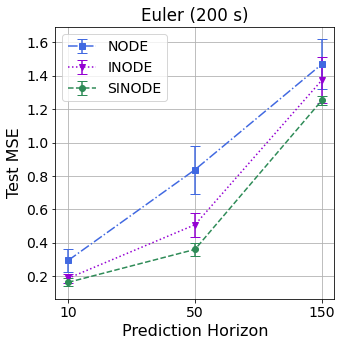

In [152]:
plot_mse(sinode_euler_mse, inode_euler_mse, node_euler_mse, 'Euler (200 s)')

### RK4 after 30 min of training (1800 seconds)

In [96]:
sinode_rk_mse = compute_mse(sinode_rk, testset)
for key,item in sinode_rk_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.079 (0.033)
Sequence length 50 with mse 0.162 (0.017)
Sequence length 150 with mse 0.582 (0.360)


In [97]:
inode_rk_mse = compute_mse(inode_rk, testset)
for key,item in inode_rk_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.068 (0.002)
Sequence length 50 with mse 0.106 (0.024)
Sequence length 150 with mse 0.646 (0.142)


In [98]:
node_rk_mse = compute_mse(node_rk, testset)
for key,item in node_rk_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.057 (0.001)
Sequence length 50 with mse 0.270 (0.022)
Sequence length 150 with mse 1.219 (0.031)


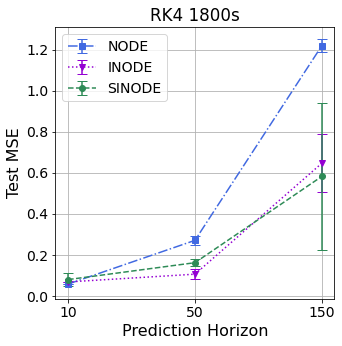

In [99]:
plot_mse(sinode_rk_mse, inode_rk_mse, node_rk_mse, 'RK4 1800s')

### Dopri5 after 2h of training (7200 s)

In [110]:
sinode_dopri_mse = compute_mse(sinode_dopri, testset)
for key,item in sinode_dopri_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.035 (0.002)
Sequence length 50 with mse 0.125 (0.007)
Sequence length 150 with mse 1.139 (0.334)


In [111]:
inode_dopri_mse = compute_mse(inode_dopri, testset)
for key,item in inode_dopri_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.039 (0.005)
Sequence length 50 with mse 0.067 (0.007)
Sequence length 150 with mse 0.426 (0.015)


In [112]:
node_dopri_mse = compute_mse(node_dopri, testset)
for key,item in node_dopri_mse.items():
    print('Sequence length {} with mse {:5.3f} ({:5.3f})'.format(key, item[0], item[1]))

Sequence length 10 with mse 0.049 (0.005)
Sequence length 50 with mse 0.325 (0.021)
Sequence length 150 with mse 1.535 (0.129)


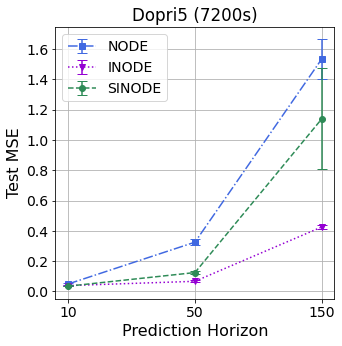

In [113]:
plot_mse(sinode_dopri_mse, inode_dopri_mse, node_dopri_mse, 'Dopri5 (7200s)')

### Plot test MSE (sinode vs rubanova)

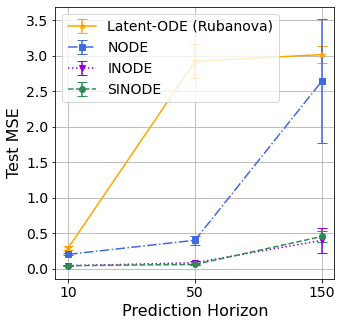

In [318]:
plot_mse_custom()

### Plot Validation MSE overtime

In [111]:
def sliding_w(array, w):
    smses = [] 
    for t in range(len(array)):
        if t<w:
            smse = np.mean(array[t:t+w])
        else:
            smse = np.mean(array[t-w:t+w])
        smses.append(smse)
    return smses


In [132]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

def plot_vl_mse(dict, t_start, t_end, integrator, w=3, ylabel='Smooth MSE'):
    vl_sinode = np.load(dict['sinode']["mse"])
    vl_s_sinode = sliding_w(vl_sinode[:,1],w)
    vl_inode = np.load(dict['inode']["mse"])
    vl_s_inode = sliding_w(vl_inode[:,1],w)
    vl_node = np.load(dict['node']["mse"])
    vl_s_node = sliding_w(vl_node[:,1],w)
    time_sinode= np.load(dict['sinode']["time"])
    time_inode = np.load(dict['inode']["time"])
    time_node =  np.load(dict['node']["time"])
    plt.figure(figsize=(14, 6), dpi=80)
    plt.plot(time_sinode[t_start:t_end,1],vl_s_sinode[t_start:t_end], '-', lw=1.5, alpha=1, label='sinode '+integrator, color='seagreen')
    plt.plot(time_inode[t_start:t_end,1],vl_s_inode[t_start:t_end],  '-', lw=1.5, alpha=1, label='inode '+integrator, color='mediumpurple')
    plt.plot(time_node[t_start:t_end,1],vl_s_node[t_start:t_end],  '-', lw=1.5, alpha=1, label='node '+integrator, color='royalblue')
#     plt.plot(time_sinode[t_start:t_end,1],vl_sinode[t_start:t_end,1], '-', lw=1.5, alpha=0.9, label='sinode '+integrator, color='seagreen')
#     plt.plot(time_inode[t_start:t_end,1],vl_inode[t_start:t_end,1],  '-', lw=1.5, alpha=0.8, label='inode '+integrator, color='mediumpurple')
#     plt.plot(time_node[t_start:t_end,1],vl_node[t_start:t_end,1],  '-', lw=1.5, alpha=0.9, label='node '+integrator, color='royalblue')
    plt.ylabel(ylabel)
    plt.ylim(-0.1, 1.75)
    plt.xlabel('Wall Clock Time (seconds)')
    plt.grid()
    lgnd = plt.legend(loc="upper right")
    for legobj in lgnd.legendHandles:
                    legobj.set_linewidth(4.0)
    plt.show()
    

### Euler

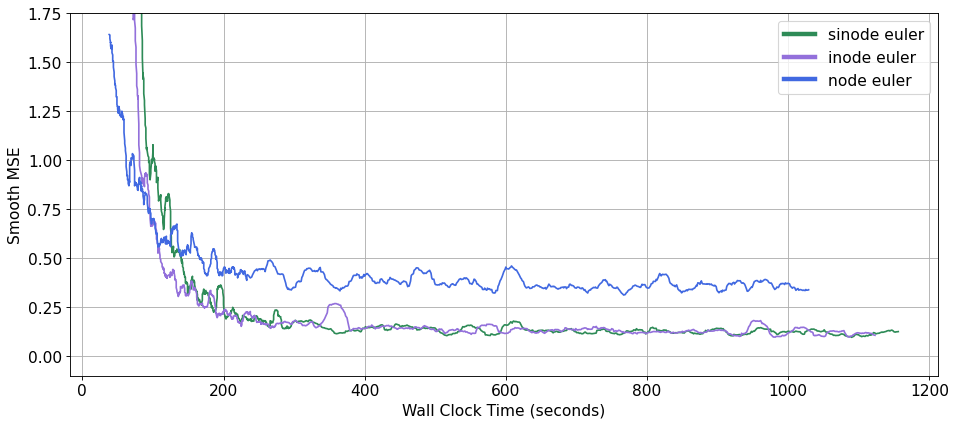

In [133]:
data = {'sinode': {"time":'../results/sin/22_03_2023-10:00/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-10:00/log_files/vl_mse.npy"},
        'inode': {"time":'../results/sin/22_03_2023-11:15/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:15/log_files/vl_mse.npy"},
        'node': {"time":'../results/sin/22_03_2023-11:17/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:17/log_files/vl_mse.npy"}
             }
plot_vl_mse(data, t_start=150,t_end=1200, integrator='euler', w=10)

### RK4

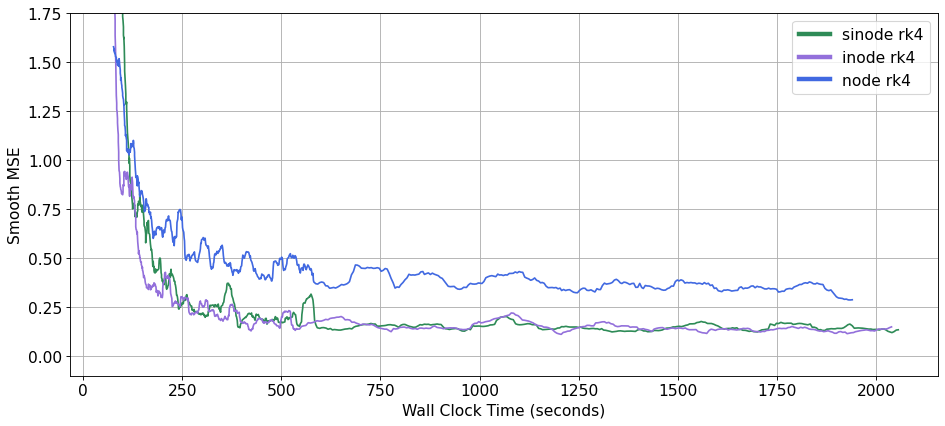

In [134]:
data = {'sinode': {"time":'../results/sin/22_03_2023-11:19/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:19/log_files/vl_mse.npy"},
        'inode': {"time":'../results/sin/22_03_2023-11:20/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:20/log_files/vl_mse.npy"},
        'node': {"time":'../results/sin/22_03_2023-11:21/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:21/log_files/vl_mse.npy"}
             }
plot_vl_mse(data, t_start=150,t_end=900, integrator='rk4', w=10)

### Dopri5

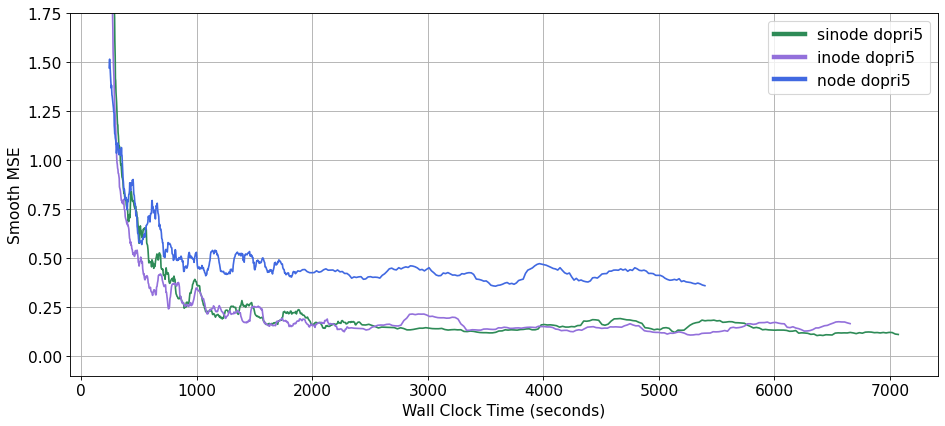

In [135]:
data = {'sinode': {"time":'../results/sin/22_03_2023-11:22/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:22/log_files/vl_mse.npy"},
        'inode': {"time":'../results/sin/22_03_2023-11:24/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:24/log_files/vl_mse.npy"},
        'node': {"time":'../results/sin/22_03_2023-11:25/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:25/log_files/vl_mse.npy"}
             }
plot_vl_mse(data, t_start=170,t_end=800, integrator='dopri5', w=10)

### Dopri w HBNODE

In [27]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

def plot_vl_mse_hbnode(dict, t_start, t_end, t_start_h, t_end_h, integrator):
    vl_sinode = np.load(dict['sinode']["mse"])
    vl_inode = np.load(dict['inode']["mse"])
    vl_node = np.load(dict['node']["mse"])
    time_sinode= np.load(dict['sinode']["time"])
    time_inode = np.load(dict['inode']["time"])
    time_node =  np.load(dict['node']["time"])
    hbnode = np.load("../results/hbnode/walker_HBNODE_rnn_251_23_03_2023-19:21_validation_time.npy", allow_pickle=True)
    plt.figure(figsize=(14, 6), dpi=80)
    plt.plot(time_sinode[t_start:t_end,1],vl_sinode[t_start:t_end,1], '-', lw=1.5, alpha=0.9, label='sinode '+integrator, color='seagreen')
    plt.plot(time_inode[t_start:t_end,1],vl_inode[t_start:t_end,1],  '-', lw=1.5, alpha=0.8, label='inode '+integrator, color='mediumpurple')
    plt.plot(time_node[t_start:t_end,1],vl_node[t_start:t_end,1],  '-', lw=1.5, alpha=0.9, label='node '+integrator, color='royalblue')
    plt.plot(hbnode[t_start_h:t_end_h,0],hbnode[t_start_h:t_end_h,1],  '-', lw=1.5, alpha=0.9, label='hbnode '+integrator, color='brown')
    plt.ylabel('MSE')
    plt.xlabel('Wall Clock Time (seconds)')
    plt.grid()
    lgnd = plt.legend(loc="upper right")
    for legobj in lgnd.legendHandles:
                    legobj.set_linewidth(4.0)
    plt.show()
    

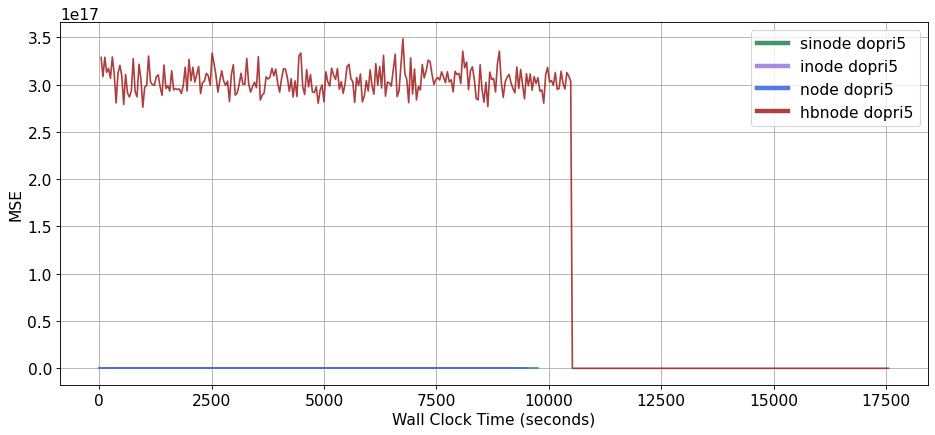

In [28]:
data = {'sinode': {"time":'../results/sin/22_03_2023-11:22/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:22/log_files/vl_mse.npy"},
        'inode': {"time":'../results/sin/22_03_2023-11:24/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:24/log_files/vl_mse.npy"},
        'node': {"time":'../results/sin/22_03_2023-11:25/log_files/time_log.npy', "mse":"../results/sin/22_03_2023-11:25/log_files/vl_mse.npy"}
             }
plot_vl_mse_hbnode(data, t_start=0,t_end=1000, t_start_h = 0, t_end_h = 500, integrator='dopri5')

In [49]:
def plot_sin(X, Xrec, show=False, fname='predictions.png', N=None, D=None, T_in = 3, T_inv=10, T=50, model_name='model', color_line='seagreen', trajectory_idx=None):
    '''
         X    - [N,T,d] 
        Xrec - [L,N,Ttest,d]
    '''
    if N is None:
        N = min(X.shape[0],6)
    if D is None:
        D = min(X.shape[-1],3)
    Xnp    = X.detach().cpu().numpy()
    Xrecnp = Xrec.detach().cpu().numpy()
    Xrecnp_mean = np.mean(Xrecnp, axis=0)
    nc,nr = D, N
    fig, axes = plt.subplots(nr, nc, figsize=(nc*10,nr*2), squeeze=False, sharex=True, sharey=True)
    for n in range(N):
        for d in range(D):
            axes[n,d].text(0.075, 0.95, 'Trajectory id: {}'.format(trajectory_idx[n]),fontsize=12, bbox=dict(facecolor='white', alpha=0.5),horizontalalignment='center', verticalalignment='top', transform=axes[n,d].transAxes)
            if n==0 and d==0:
                axes[n,d].plot(Xrecnp_mean[n,:,d].T, '-', color=color_line, lw=1.0, alpha=1, label=model_name)
                axes[n,d].plot(Xnp[n,:,d].T, '-', color='black', lw=1.5, label='Ground Truth')
                leg = axes[n,d].legend(ncol=3, prop={'size': 14}, loc='upper center', bbox_to_anchor=(0.5, 1.4))
                # set the linewidth of each legend object
                for legobj in leg.legendHandles:
                    legobj.set_linewidth(4.0)

            else:
                axes[n,d].plot(Xrecnp_mean[n,:,d].T, '-', color=color_line, lw=0.7, alpha=1)
                axes[n,d].plot(Xnp[n,:,d].T, '-', color='black', lw=1.5)
            axes[n,d].plot(Xrecnp[:,n,:,d].T, '--', color=color_line, lw=0.7, alpha=0.2)
            axes[n,d].axvline(x=T_in,linewidth=2, color='grey', ls='-')
            if T_inv is not None:
                axes[n,d].axvline(x=T_inv,linewidth=2, color='grey', ls='-.')
            axes[n,d].axvline(x=T,linewidth=2, color='grey', ls=':')
            axes[n,d].set_xlim([-1, 150])
    plt.tight_layout()
    # lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels, bbox_to_anchor=(0.49, 0.49, 0.5, 0.5), prop={'size': 14})
    if show:
        plt.show()
    else:
        plt.savefig(fname)
        plt.close()

In [71]:
test_idx = [2, 6,24]
plotL= 20
forecast_te = 1

In [74]:
Xrec_te, ztL_te, _, _, C_full = sinode_dopri(X_te[test_idx],   L=plotL, T_custom=forecast_te*X_te.shape[1])

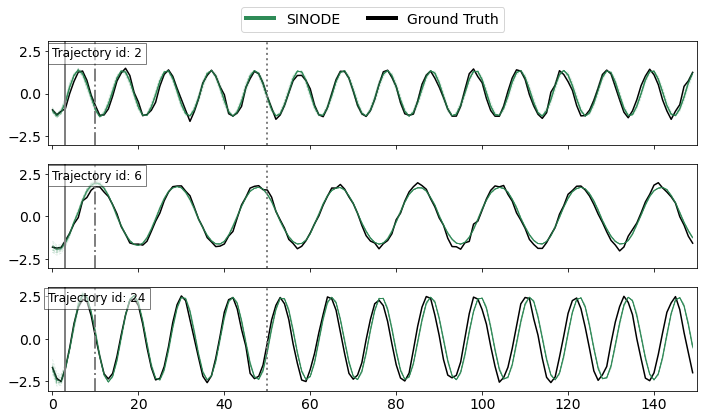

In [75]:
plot_sin(X_te[test_idx], Xrec_te, show=True, T_in=3, N=3, T_inv=10, T=50, model_name='SINODE', color_line='seagreen', trajectory_idx=test_idx)

In [76]:
Xrec_te, ztL_te, _, _, C_full = inode_dopri(X_te[test_idx],   L=plotL, T_custom=forecast_te*X_te.shape[1])

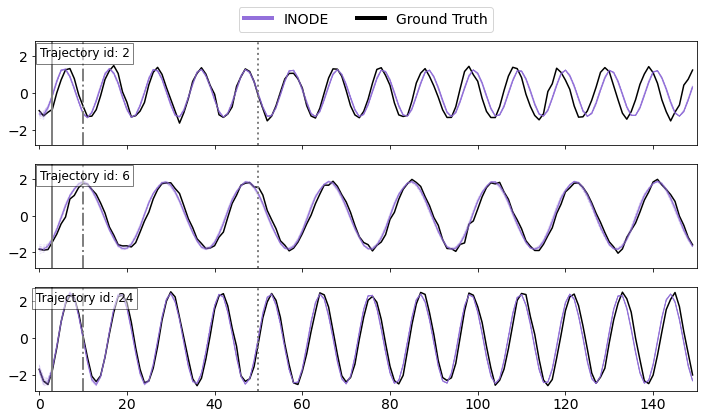

In [77]:
plot_sin(X_te[test_idx], Xrec_te, show=True, T_in=3, N=3, T_inv=10, T=50, model_name='INODE', color_line='mediumpurple', trajectory_idx=test_idx)

In [78]:
Xrec_te, ztL_te, _, _, C_full = node_dopri(X_te[test_idx],   L=plotL, T_custom=forecast_te*X_te.shape[1])

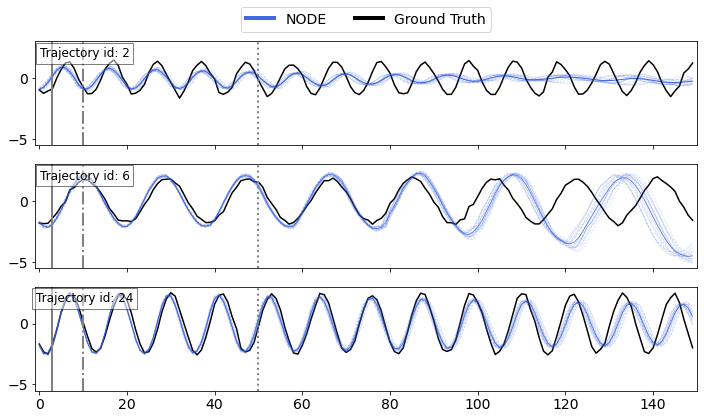

In [79]:
plot_sin(X_te[test_idx], Xrec_te, show=True, T_in=3, N=3, T_inv=10, T=50, model_name='NODE', color_line='royalblue', trajectory_idx=test_idx)